In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmqx2


In [14]:
driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
qubitOp = ferOp.mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

In [15]:
qubitOp.num_qubits

2

In [2]:
from qiskit import Aer, execute
backend = BasicAer.get_backend("statevector_simulator")

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(backend)
    print(ret["opt_params"])
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

[ 2.27134154e-08  2.94301749e-08 -7.19015210e-02]
Interatomic Distance: 0.5 VQE Result: -1.055159794447967 Exact Energy: [-1.05515979]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-3.88129373e-09  3.88129373e-09 -8.70238839e-02]
Interatomic Distance: 0.6 VQE Result: -1.1162860068309413 Exact Energy: [-1.11628601]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[ 4.43748775e-08  2.37400552e-08 -1.04861643e-01]
Interatomic Distance: 0.7 VQE Result: -1.1361894540111397 Exact Energy: [-1.13618945]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[ 2.45270616e-08  3.99326844e-08 -1.25516138e-01]
Interatomic Distance: 0.8 VQE Result: -1.134147666620068 Exact Energy: [-1.13414767]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[ 0.00000000e+00  1.16929885e-08 -1.49542215e-01]
Interatomic Distance: 0.9 VQE Result: -1.1205601297760261 Exact Energy: [-1.12056028]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[ 0.00000000e+00  1.33510306e-08 -1.76318958e-01]
Interatomic Distance: 1.0 VQE Result: -1.101150318806139 Exact Energy: [-1.10115033]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-7.58502892e-09  0.00000000e+00 -2.06889438e-01]
Interatomic Distance: 1.1 VQE Result: -1.0791929449548827 Exact Energy: [-1.07919294]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-4.42387626e-08  3.97537628e-08 -2.41363316e-01]
Interatomic Distance: 1.2 VQE Result: -1.0567407449300041 Exact Energy: [-1.05674075]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[ 1.87719468e-08  6.34754304e-08 -2.79390381e-01]
Interatomic Distance: 1.3 VQE Result: -1.0351862637975306 Exact Energy: [-1.03518627]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-2.91849499e-08  1.13204101e-08 -3.20379578e-01]
Interatomic Distance: 1.4 VQE Result: -1.0154682470608276 Exact Energy: [-1.01546825]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-2.45405060e-08  3.10600987e-09 -3.63382557e-01]
Interatomic Distance: 1.5 VQE Result: -0.9981493525225241 Exact Energy: [-0.99814935]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-2.84559358e-08 -6.94092212e-10 -4.07196674e-01]
Interatomic Distance: 1.6 VQE Result: -0.9834727288651173 Exact Energy: [-0.98347273]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-1.33837983e-08 -1.23488746e-08 -4.50520517e-01]
Interatomic Distance: 1.7 VQE Result: -0.971426688452816 Exact Energy: [-0.97142669]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-2.95255589e-08 -1.46243978e-08 -4.91427507e-01]
Interatomic Distance: 1.8 VQE Result: -0.9618166585233299 Exact Energy: [-0.96181695]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


[-1.90547693e-08  2.76680391e-09 -5.31032884e-01]
Interatomic Distance: 1.9 VQE Result: -0.9543388539973559 Exact Energy: [-0.95433885]


/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:344: DeprecationWarning: opt_params deprecated, use optimal_point property.
  DeprecationWarning)


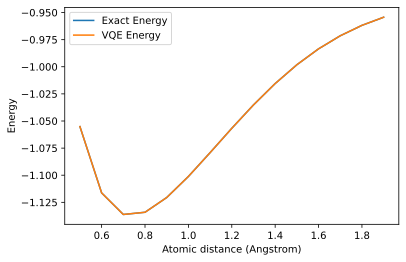

In [3]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.savefig("H2_statevector.png")
plt.show()

In [5]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_ourense")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    print(ret["opt_params"])
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

/home/sonobe/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',


[0. 0. 0.]
Interatomic Distance: 0.5 VQE Result: -0.9992553455303745 Exact Energy: [-1.05515979]


/home/sonobe/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',


[0.00306792 0.00306792 0.00306792]
Interatomic Distance: 0.6 VQE Result: -1.0514218094525247 Exact Energy: [-1.11628601]


/home/sonobe/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',


[0. 0. 0.]
Interatomic Distance: 0.7 VQE Result: -1.0841250135964353 Exact Energy: [-1.13618945]


/home/sonobe/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',


[-0.00675953  0.00587437  0.00476468]
Interatomic Distance: 0.8 VQE Result: -1.0756016789301035 Exact Energy: [-1.13414767]


KeyboardInterrupt: 

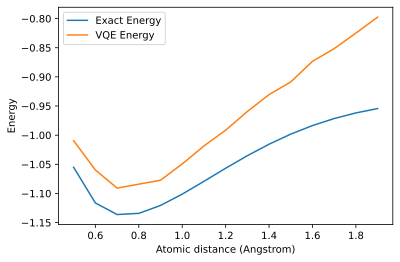

<Figure size 432x288 with 0 Axes>

In [3]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.savefig("H2_qc.png")